In [17]:
import numpy as np
import pandas as pd
from scipy.linalg import svd
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection


# Code

In [ ]:
def euclidean_distance(x1, x2):
    """Compute pairwise Euclidean distances between two data points.
    
    Parameters
    ----------
    x1 : array, shape (N, 4)
        First set of data points.
    x2 : array, shape (M, 4)
        Second set of data points.
    
    Returns
    -------
    distance : float array, shape (N, M)
        Pairwise Euclidean distances between x1 and x2.
    """
    return np.sqrt(np.sum((x1[:, None] - x2[None])**2, -1))

In [ ]:
def get_neighbors_labels(X_train, y_train, X_new, k):
    """Get the labels of the k nearest neighbors of the datapoints x_new.
    
    Parameters
    ----------
    X_train : array, shape (N_train, 4)
        Training features.
    y_train : array, shape (N_train)
        Training labels.
    X_new : array, shape (M, 4)
        Data points for which the neighbors have to be found.
    k : int
        Number of neighbors to return.
        
    Returns
    -------
    neighbors_labels : array, shape (M, k)
        Array containing the labels of the k nearest neighbors.
    """
    distances = euclidean_distance(X_new, X_train)
    nearest = np.argsort(distances, axis=1)[:, :k]
    return y_train[nearest]

In [ ]:
def get_response(neighbors_labels, num_classes=3):
    """Predict label given the set of neighbors.
    
    Parameters
    ----------
    neighbors_labels : array, shape (M, k)
        Array containing the labels of the k nearest neighbors per data point.
    num_classes : int
        Number of classes in the dataset.
    
    Returns
    -------
    y : int array, shape (M,)
        Majority class among the neighbors.
    """
    class_votes = (neighbors_labels[:, :, None] == np.arange(num_classes)[None, None]).sum(1)
    return np.argmax(class_votes, 1)

In [ ]:
def compute_accuracy(y_pred, y_test):
    """Compute accuracy of prediction.
    
    Parameters
    ----------
    y_pred : array, shape (N_test)
        Predicted labels.
    y_test : array, shape (N_test)
        True labels.
    """
    return np.mean(y_pred == y_test)

In [ ]:
def predict(X_train, y_train, X_test, k):
    """Generate predictions for all points in the test set.
    
    Parameters
    ----------
    X_train : array, shape (N_train, 4)
        Training features.        
    y_train : array, shape (N_train)
        Training labels.
    X_test : array, shape (N_test, 4)
        Test features.
    k : int
        Number of neighbors to consider.
    
    Returns
    -------
    y_pred : array, shape (N_test)
        Predictions for the test data.
    """
    neighbors = get_neighbors_labels(X_train, y_train, X_test, k)
    y_pred = get_response(neighbors)
    return y_pred

In [ ]:
##  Tesontinf

# generate predictions
k = 3
y_pred = predict(X_train, y_train, X_test, k)
accuracy = compute_accuracy(y_pred, y_test)
print('Accuracy = {0}'.format(accuracy))

In [ ]:
# model_selection.train_test_split(X, y, random_state=123, test_size=(1 - split))

# Data preview / Cleaning

In [59]:
df = pd.read_csv('../dataset_mood_smartphone.csv')
df = df.drop('Unnamed: 0', axis = 1)
df[['day', 'time']] = df['time'].str.split(' ', expand=True)
df.head()

,id,time,variable,value,day
0,AS14.01,13:00:00.000,mood,6.0,2014-02-26
1,AS14.01,15:00:00.000,mood,6.0,2014-02-26
2,AS14.01,18:00:00.000,mood,6.0,2014-02-26
3,AS14.01,21:00:00.000,mood,7.0,2014-02-26
4,AS14.01,09:00:00.000,mood,6.0,2014-02-27


In [65]:
columns = ['number', 'min', 'max']
rows = ['id','time','day']

In [74]:
table = pd.DataFrame(index = rows,columns= columns)

In [67]:
variables = df['variable'].unique()
ids = df['id'].unique()
days = df['day'].unique()
times = df['time'].unique()

In [77]:
table.loc['id']

number    NaN
min       NaN
max       NaN
Name: id, dtype: object

In [68]:
low_range = df.min()
up_range = df.max()

In [78]:
table.loc['id'] = [ids.shape[0],low_range['id'], up_range['id']]
table.loc['day'] = [days.shape[0],low_range['day'], up_range['day']]
table.loc['time'] = [times.shape[0],low_range['time'], up_range['time']]

In [79]:
table

,number,min,max
id,27,AS14.01,AS14.33
time,333445,00:00:00.000,23:59:59.946
day,113,2014-02-17,2014-06-09


In [84]:
var_range = []
for i,var in enumerate(variables):
    data = df[df['variable'] == var]['value']
    var_range += [np.array([np.max(data),np.min(data)])]

In [91]:
table_var = pd.DataFrame(index = [variables],columns= ['up_range', 'low_range'])

In [92]:
for i,var in enumerate(variables):
    table_var.iloc[i] = var_range[i]

In [93]:
table_var

,up_range,low_range
mood,10.0,1.0
circumplex.arousal,2.0,-2.0
circumplex.valence,2.0,-2.0
activity,1.0,0.0
screen,9867.007,0.035
call,1.0,1.0
sms,1.0,1.0
appCat.builtin,33960.246,-82798.871
appCat.communication,9830.777,0.006
appCat.entertainment,32148.677,-0.011


In [9]:
zeros_var = np.zeros(variables.shape[0])

for i,var in enumerate(variables):
    df_min = df[df['variable'] == var]
    zeros_var[i] = df_min.isna().sum().sum()
print(zeros_var)

[  0.  46. 156.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]


In [10]:
zeros_ids = np.zeros(ids.shape[0])

for i,var in enumerate(ids):
    df_min = df[df['id'] == var]
    zeros_ids[i] = df_min.isna().sum().sum()
print(zeros_ids)

[17.  0.  0.  7.  3.  2.  3.  6. 10.  0.  0. 11. 43. 11.  0.  0.  0. 35.
  1.  2.  0. 39.  0.  0.  0.  0. 12.]


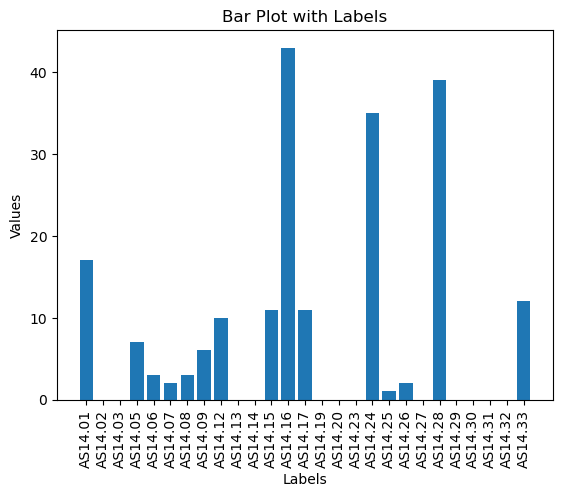

In [12]:

fig, ax = plt.subplots()


ax.bar(ids, zeros_ids)

ax.set_xlabel('Labels')
ax.set_ylabel('Values')
ax.set_title('Bar Plot with Labels')
plt.xticks(rotation='vertical')

plt.show()

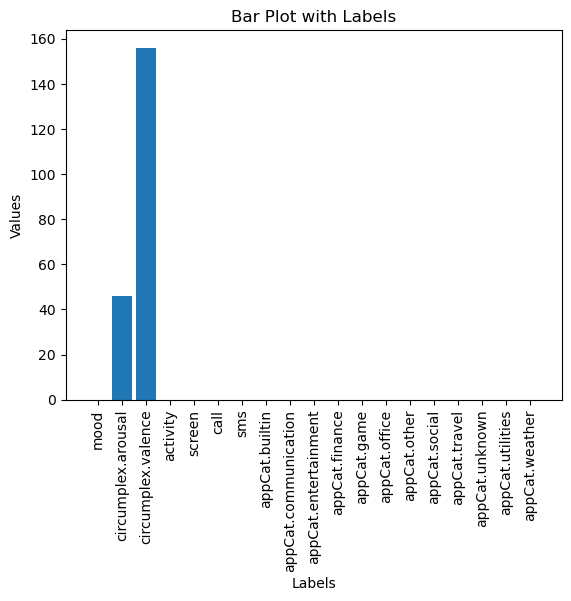

In [34]:

fig, ax = plt.subplots()


ax.bar(variables, zeros_var)

ax.set_xlabel('Labels')
ax.set_ylabel('Values')
ax.set_title('Bar Plot with Labels')
plt.xticks(rotation='vertical')

plt.show()


In [ ]:
df_13 = df[df['id'] == 'AS14.13']

In [19]:
df.isna().sum().sum()

202

# Task: 1,B

In [ ]:
def moving_average(data):
    